In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv("https://www.dropbox.com/s/glmbcyopi24m2ni/final_project_data.csv?dl=1")
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35 UTC,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00 UTC,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19 UTC,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47 UTC,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16 UTC,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615962 entries, 0 to 615961
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                615962 non-null  object 
 1   pickup_datetime    615962 non-null  object 
 2   pickup_longitude   615962 non-null  float64
 3   pickup_latitude    615961 non-null  float64
 4   dropoff_longitude  615959 non-null  float64
 5   dropoff_latitude   615959 non-null  float64
 6   passenger_count    615961 non-null  float64
 7   fare_amount        615961 non-null  float64
dtypes: float64(6), object(2)
memory usage: 37.6+ MB


1. Разведочный анализ данных

In [ ]:
# Удаление пропусков
df = df.dropna()
# Удаление столбца, дублирующего данные
df = df.drop(['key'], axis=1)
# Декомпозируем pickup_datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['day'] = df.pickup_datetime.dt.day
df['hour'] = df.pickup_datetime.dt.hour + (df.pickup_datetime.dt.minute > 30).astype(int)
df.loc[df['hour'] == 24, 'hour'] = 0
df = df.drop('pickup_datetime', axis=1)

In [ ]:
# Поиск выбросов
df.describe().loc[['mean', 'min', 'max'], :]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
mean,-72.528287,39.93256,-72.531908,39.917904,1.685127,11.33218,2011.741072,6.263397,15.70592,13.452856
min,-1280.547368,-3447.91509,-3328.756240,-3493.651853,0.000000,-45.00000,2009.000000,1.000000,1.00000,0.000000
max,2512.533050,1629.00420,2058.322398,1640.072227,6.000000,370.00000,2015.000000,12.000000,31.00000,23.000000


In [ ]:
# Выбросы в данных:
# pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude: таких отклонений от среднего для координат в одном городе быть не может.
# passenger_count: 0 пассажиров.
# fare_amount: неположительная плата за проезд.

# Удаление выбросов

for col in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:
  mean = df[col].mean()
  std = df[col].std()
  lower = mean - 3 * std
  upper = mean + 3 * std
  df = df[(df[col] >= lower) & (df[col] <= upper)]

df = df[df.passenger_count > 0]
df = df[df.fare_amount > 0]

In [ ]:
df.describe().loc[['mean', 'min', 'max'], :]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
mean,-73.975281,40.750980,-73.974424,40.751283,1.690894,11.323142,2011.739412,6.265634,15.701559,13.454773
min,-77.253142,37.828900,-81.006287,38.464417,1.000000,0.010000,2009.000000,1.000000,1.000000,0.000000
max,-68.016667,43.259652,-67.750000,43.920694,6.000000,370.000000,2015.000000,12.000000,31.000000,23.000000


In [ ]:
df.shape

(601218, 10)

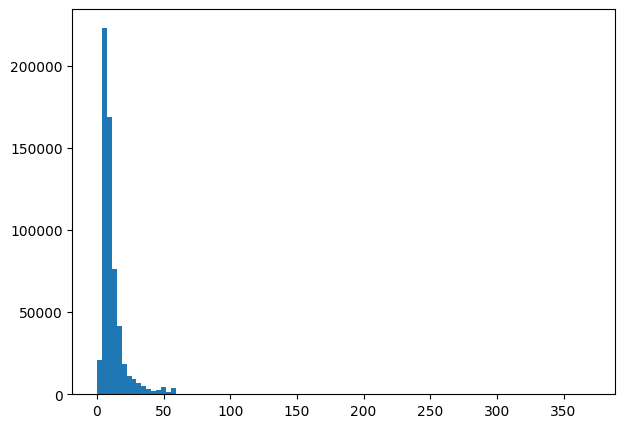

In [ ]:
# Оценим визуально распределение целевой переменной
plt.figure(figsize=(7, 5))
plt.hist(df.fare_amount, bins=100)
plt.show()

In [ ]:
# Прологарифмируем целевую переменную, чтобы сделать распределение ближе к нормальному
# Для предсказаний модели будем выполнять обратную операцию
df.fare_amount =  np.log1p(df.fare_amount)

In [ ]:
# Закодируем признаки, связанные с временем поездки
# Их можно рассматривать как категориальные
season_dct = {
    "winter": [12, 1, 2],
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "autumn": [9, 10, 11],
}

month_dct = {
    "start_month": list(range(1, 11)),
    "middle_month": list(range(11, 21)),
    "end_month": list(range(21, 32)),
}

time_of_day_dct = {
    "night": [23, 0, 1, 2, 3, 4, 5],
    "morning": list(range(6, 12)),
    "day": list(range(12, 17)),
    "evening": list(range(17, 23)),
}

lst_of_dct = [(season_dct, 'month'), (month_dct, 'day'), (time_of_day_dct, 'hour')]

for dct, feature in lst_of_dct:
  for key in dct:
    df[key] = 0
    df.loc[df.loc[:, feature].isin(dct[key]), key] = 1
df = df.drop(['month', 'hour'], axis=1)

In [ ]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,day,winter,spring,summer,autumn,start_month,middle_month,end_month,night,morning,evening
0,-73.959075,40.783316,-73.959087,40.783345,1.0,1.252763,2011,1,0,0,0,1,0,0,1,0,0,0
1,-73.931612,40.771060,-73.929097,40.760542,1.0,1.871802,2013,0,0,0,0,1,0,1,0,0,0,1
2,-73.997929,40.740983,-74.007197,40.727725,2.0,2.014903,2012,0,0,1,0,0,0,0,1,0,0,1
3,-73.980608,40.742449,-73.985609,40.755807,1.0,2.014903,2010,1,0,0,0,1,0,0,1,0,0,0
4,-74.008884,40.720314,-73.983280,40.722350,1.0,2.572612,2011,0,1,0,0,0,0,1,0,0,0,1


2. Построение базовой модели

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(Ridge())),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def custom_r2_score(model, X, y):
  y_pred = model.predict(X)
  return r2_score(np.expm1(y), np.expm1(y_pred))

def cur_r2_score(X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  params = {'model__max_depth': range(3, 11)}
  grid = GridSearchCV(pipeline, param_grid=params, scoring=custom_r2_score, cv=3, n_jobs=-1)
  grid.fit(X_train, y_train)

  tree = grid.best_estimator_
  return round(r2_score(np.expm1(y_test), np.expm1(tree.predict(X_test))), 2)

y = df['fare_amount']
X = df.drop('fare_amount', axis=1)

print(cur_r2_score(X, y))

0.74


3. Улучшение факторов, не связанных с конкретной моделью для предсказания целевой переменной

3.1 Добавление новых признаков

In [ ]:
# Добавим новый признак: Манхэттенское расстояние между местом посадки и высадки
X['manhattan_distance'] = np.abs(X['dropoff_latitude'] - X['pickup_latitude']) + np.abs(X['dropoff_longitude'] - X['pickup_longitude'])
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,winter,spring,summer,autumn,start_month,middle_month,end_month,night,morning,evening,manhattan_distance
0,-73.959075,40.783316,-73.959087,40.783345,1.0,2011,1,0,0,0,1,0,0,1,0,0,0,0.000041
1,-73.931612,40.771060,-73.929097,40.760542,1.0,2013,0,0,0,0,1,0,1,0,0,0,1,0.013033
2,-73.997929,40.740983,-74.007197,40.727725,2.0,2012,0,0,1,0,0,0,0,1,0,0,1,0.022526
3,-73.980608,40.742449,-73.985609,40.755807,1.0,2010,1,0,0,0,1,0,0,1,0,0,0,0.018359
4,-74.008884,40.720314,-73.983280,40.722350,1.0,2011,0,1,0,0,0,0,1,0,0,0,1,0.027640


In [ ]:
print(cur_r2_score(X, y))

0.8


In [ ]:
# Альтернативный вариант: Евклидово расстояние
X = X.drop('manhattan_distance', axis=1)
X['euclidian_distance'] = ((X['dropoff_latitude'] - X['pickup_latitude'])**2 + (X['dropoff_longitude'] - X['pickup_longitude'])**2)**0.5
print(cur_r2_score(X, y))

0.8


Вывод: добавление любого из признаков одинаково повышает качество модели, оставим Евклидово расстояние.

3.2 Изменение модели для отбора признаков

In [ ]:
"""
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(estimator=Lasso(max_iter=10000), threshold='median')),
    ('model', DecisionTreeRegressor(random_state=42))
])

print(cur_r2_score(X, y))
"""

"\nfrom sklearn.linear_model import Lasso\n\npipeline = Pipeline([\n    ('features', PolynomialFeatures(degree=2)),\n    ('scaler', StandardScaler()),\n    ('reduction', SelectFromModel(estimator=Lasso(max_iter=10000), threshold='median')),\n    ('model', DecisionTreeRegressor(random_state=42))\n])\n\nprint(cur_r2_score(X, y))\n"

Вывод: изменений в качестве по сравнению с Ridge нет, время обучения модели значительно увеличивается.

3.3 Изменение порядка полиномиальных признаков

In [ ]:
"""
# Попробуем увеличить порядок полиномиальных признаков до 3-го
pipeline = Pipeline([
    ('features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(Ridge())),
    ('model', DecisionTreeRegressor(random_state=42))
])

print(cur_r2_score(X, y))
"""

"\n# Попробуем увеличить порядок полиномиальных признаков до 3-го\npipeline = Pipeline([\n    ('features', PolynomialFeatures(degree=3)),\n    ('scaler', StandardScaler()),\n    ('reduction', SelectFromModel(Ridge())),\n    ('model', DecisionTreeRegressor(random_state=42))\n])\n\nprint(cur_r2_score(X, y))\n"

Вывод: время обучения модели значительно увеличивается, используем данный способ для повышения качества модели в последнюю очередь.

4. Использование LightGBM для предсказания целевой переменной

4.1 LightGBM c одним подобранным гиперпараметром

In [ ]:
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(Ridge())),
    ('model', LGBMRegressor(random_state=42, device='gpu', verbose=-1))
])

param_grid = {
    'model__max_depth': range(3, 11)
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_r2_score,
    cv=3,
    n_jobs=3
)

grid.fit(X_train, y_train)
model = grid.best_estimator_

round(r2_score(np.expm1(y_test), np.expm1(model.predict(X_test))), 2)

0.83

LightGBM c одним подобранным гиперпараметром показал качество выше, чем решающее дерево. Подберем и другие гиперпараметры. Запустим процесс обучения в Yandex DataSphere.

4.2 Подбор гиперпараметров для LightGBM

In [ ]:
pipeline = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(Ridge())),
    ('model', LGBMRegressor(random_state=42, device='gpu', verbose=-1))
])

param_grid = {
    # Гиперпараметры LightGBM
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 9, 13],

    # Гиперпараметры SelectFromModel
    'reduction__estimator__alpha': [0.1, 1, 10.0]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_r2_score,
    cv=3,
    n_jobs=3
)

grid.fit(X_train, y_train)
model = grid.best_estimator_

round(r2_score(np.expm1(y_test), np.expm1(model.predict(X_test))), 2)

0.83

4.3 Обучение итоговой модели с подобранными гиперпараметрами. Увеличим степень полиномиальных признаков.

In [ ]:
params = {'model__learning_rate': 0.1,
         'model__max_depth': 10,
         'model__n_estimators': 500,
         'reduction__estimator__alpha': 0.1}

model = Pipeline([
    ('features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('reduction', SelectFromModel(Ridge())),
    ('model', LGBMRegressor(random_state=42, device='gpu', verbose=-1))
])

model.set_params(**params)
model.fit(X_train, y_train)

round(r2_score(np.expm1(y_test), np.expm1(model.predict(X_test))), 2)

0.84

In [ ]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

**Итог**

Результирующее значение метрики $R^{2}$ - 0.84.

Модель была сохранена в файл.